# Last general COVID-19 stats distributed by countries.

## Goal.

To find correlation between confirmed cases, deaths, and testing and other variables of potential interest based on daily-updated dataset from [this public source](https://github.com/owid/covid-19-data/tree/master/public/data).

## Conclusions:
- there is evident correlation between number of total tests, total cases and total deaths fields that is expectedly, the more are tests done in each country the more are confirmed cases and deaths.
- but not all countries have stats about done testing, only 85 among 208 have non-null testing values. Based on the country distribution of available covid tests per million we can see that the most tests are made in Russia and USA that is logically becasue they have high number of poplation. We can say that New Zealand, Australia and Europe have high percent of made tests, when Asian countries number of tests are not enought comparing to their high average population (it may be due to lack of China testing data). Also South America and Africa countries have low number of done tests.
- rich countries with high gross domestic product have the most covid testing and confirmed cases, they are mainly rich Europian, North America, Oceania and Asian countries. We can see that some countries with high gdp_per_capita have low tests confirmation density that is rather because of low testing level.
- intresting here are Australia, New Zealand, Austria, Malta, Norway, Lithuania, Estonia, Latvia where testing level is above verage but confirmation density is low.
- there is no relation between countries population density and covid confirmation level.
- generally the higher is share of old population the higher is covid deaths level, but not all countries with old population have high covid death level, generally they are countries with low testing level, no tests - no cases - no deaths related with covid.
- there are countries which have share of old population above average and high covid confirmation level but their deaths level is lower then average: Singapore, Belarus, Iceland, Israel, Puerto Rico, Serbia - this may indicate to good medicine level or another unnkown factors.
- based on some of European countries with high testing level we can say that high share of female smoking may related with increaseing deaths attributed to COVID-19 but there is no enough testings to get accurate stats (about 65% of all countries with low covid deaths and high share of women who smoke have missing or low covid testing level).
- countries with low covid deaths and high share of women who smoke which have high covid testing and confirmation level are the same who has also high share of old population: Belarus, Iceland, Israel, Serbia  - it may be useful to find out about their covid prevention policy.
- cardiovascular disease are negatively correlated with total deaths attributed to COVID-19 but one again it can be related with lack or low covid testing level.

# [ETL] Reading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  # used here to surpress FutureWarning
import plotly as py  # interactive plotting
import plotly.graph_objs as go
import cufflinks as cf  # interactive plotting made easy (pandas style)

# Using plotly + cufflinks in offline mode
from plotly.offline import iplot, init_notebook_mode
cf.go_offline(connected=True)
init_notebook_mode(connected=True)

pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100
covid=pd.read_csv("owid-covid-data.csv")
covid.shape

(28453, 34)

# [ETL] Condensing dataset to today's stats

In [2]:
grouped = covid.groupby('location')
covid_grouped=grouped["total_tests", "total_tests_per_thousand"]
covid_test_max=covid_grouped.max()
covid_test_max.shape

(212, 2)

In [3]:
covid['date'] = pd.to_datetime(covid['date'])
lastday=covid.loc[covid['date']==pd.Timestamp("today").strftime("%Y-%m-%d")]
lastday.shape

(209, 34)

In [4]:
new_cols=lastday.columns[lastday.notnull().sum() > 30]
survey=lastday[new_cols]
survey.loc[survey['location']=='Russia', 'continent']='Russia'
survey.loc[survey['location']=='United States', 'continent']='USA'
survey=survey.drop(survey.index[-1])
survey=pd.merge(left=survey, right=covid_test_max, on="location")
survey.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208 entries, 0 to 207
Data columns (total 28 columns):
iso_code                      208 non-null object
continent                     208 non-null object
location                      208 non-null object
date                          208 non-null datetime64[ns]
total_cases                   208 non-null float64
new_cases                     208 non-null float64
total_deaths                  208 non-null float64
new_deaths                    208 non-null float64
total_cases_per_million       208 non-null float64
new_cases_per_million         208 non-null float64
total_deaths_per_million      208 non-null float64
new_deaths_per_million        208 non-null float64
population                    208 non-null float64
population_density            197 non-null float64
median_age                    184 non-null float64
aged_65_older                 181 non-null float64
aged_70_older                 183 non-null float64
gdp_per_capita          

# Find correlations

In [5]:
correlations=survey.corr(method='pearson')

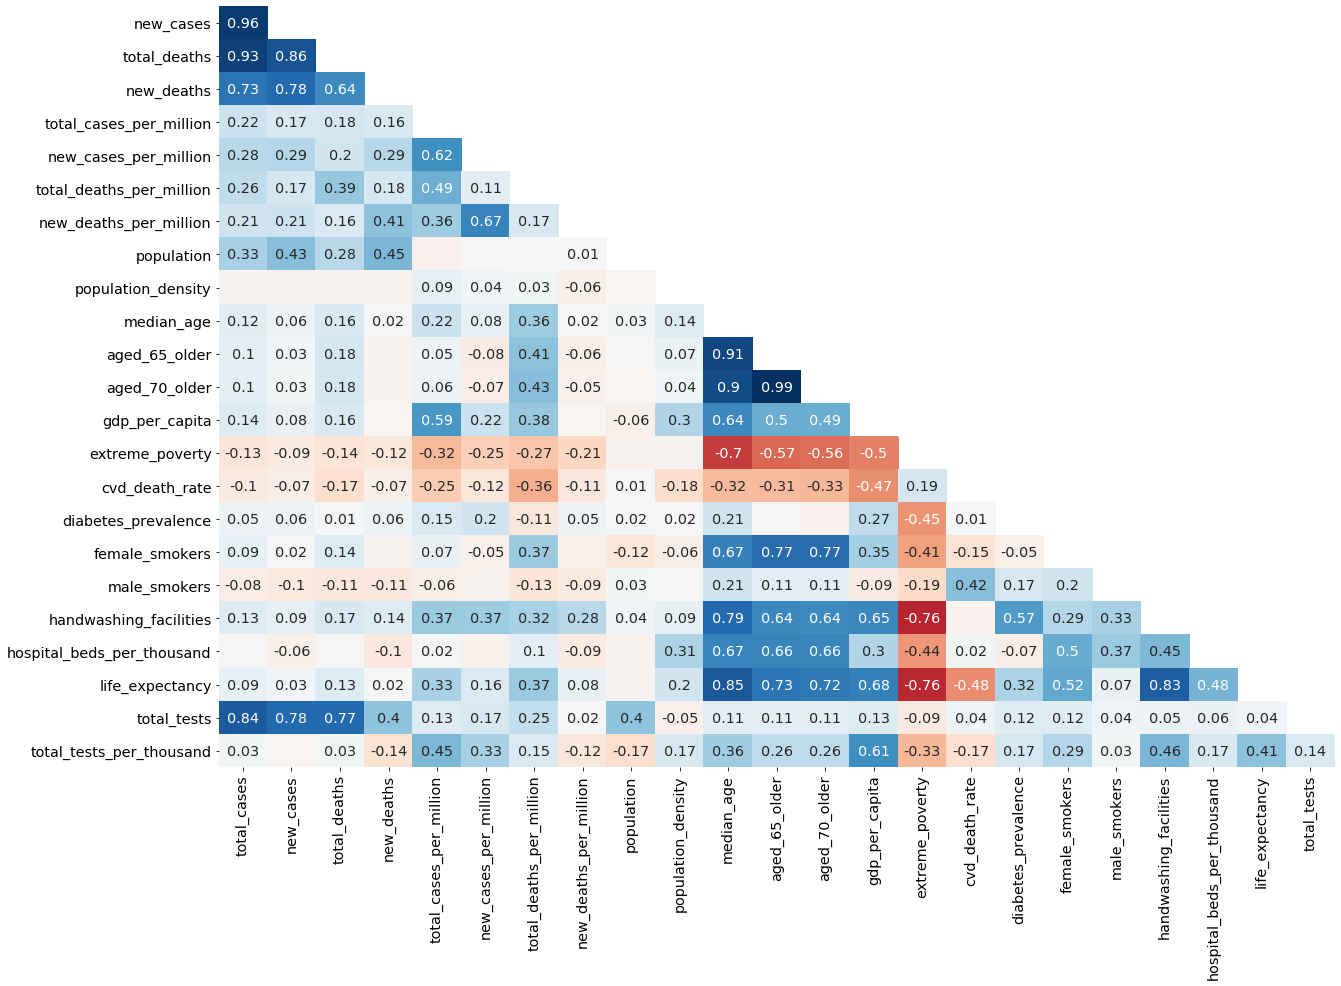

In [6]:
def plot_correlations(df):
    # create a triangular mask to avoid repeated values and make
    # the plot easier to read
    df = df.iloc[1:, :-1]
    mask = np.triu(np.ones_like(df), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(df, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()

plot_correlations(correlations)

Our interesting are dependencies between fields attributed to covid cases, deaths and testing and other country indicator fields with positive correlation more than 0.3 and with negative correlation less than -0.3:
- we can see evident correlation between number of total tests, total cases and total deaths fields that is expectedly, the more are tests done in each country the more are confirmed cases and deaths.
- also we can notice more potential of rich countries of making more tests: 0.61 between gdp_per_capita and total_tests_per_thousand. The same positive correaltion is between gross domestic product and total_cases_per_million - 0.59. Related to the gross domestic product indicator is here share of the population living in extreme poverty - extreme_poverty, that shows some negative correlation with cases and testing.
- some expectations are confirmed by positive correlation between share of the population that is 65-70 years and older and total_deaths_per_million
- intresting can be weak positive correlation between share of women who smoke and deaths, as well as negative correlation between death rate from cardiovascular disease and covid deaths

# Plotting total and per million people confirmed cases, deaths, and testing distributed by countries.

In [7]:
values=survey[['location', 'total_tests', 'total_cases', 'total_deaths']]
values.set_index('location', inplace=True)
name=survey['location']
totals = pd.DataFrame(data=values,index=name)
totals=totals.dropna(axis=0)
totals=totals.sort_values(ascending=False, by='total_tests')
totals=totals.loc[totals['total_tests']>300000]
totals.shape

(51, 3)

In [8]:
# build stacked bar to total tests, cases and deaths of all countries with total tests above 300K
totals.astype(int).iplot(kind="bar", barmode="stack", yTitle='Share of total tests, cases and deaths',
                            title='Total tests, cases and deaths distribution by countries, <br> (Countries with total tests > 300K)')

In [9]:
per_mill=survey[['location', 'total_cases_per_million', 'total_deaths_per_million']]
per_mill['total_tests_per_million']=(survey['total_tests_per_thousand']*1000000)/1000
per_mill=per_mill[['location', 'total_tests_per_million', 'total_cases_per_million', 'total_deaths_per_million']]
per_mill.set_index('location', inplace=True)
name=survey['location']
values_per_million = pd.DataFrame(data=per_mill,index=name)
values_per_million=values_per_million.dropna(axis=0)
values_per_million=values_per_million.sort_values(ascending=False, by='total_tests_per_million')
values_per_million=values_per_million.loc[values_per_million['total_tests_per_million']>25000]
values_per_million.shape

(47, 3)

In [10]:
# build stacked bar to total tests, cases and deaths per million of all countries with total tests per million above 25K
values_per_million.astype(int).iplot(kind="bar", barmode="stack", yTitle='Share of total tests, cases and deaths per million',
                            title='Total tests, cases and deaths per million distribution by countries, <br> (Countries with total tests per million > 25K)')

In [11]:
split_continent=survey.copy()
split_continent['total_tests_per_million']=(split_continent['total_tests_per_thousand']*1000000)/1000
grouped = split_continent.groupby('continent')
split_continent_grouped=grouped['total_tests_per_million', 'total_cases_per_million', 'total_deaths_per_million']
test_per_mill_mean_c=split_continent_grouped.mean()
test_per_mill_mean_c=test_per_mill_mean_c.sort_values(ascending=False, by="total_tests_per_million")
test_per_mill_mean_c

,total_tests_per_million,total_cases_per_million,total_deaths_per_million
continent,,,
Russia,142204.000000,4668.198000,69.627000
USA,105312.000000,8726.924000,392.586000
Oceania,90868.000000,401.773750,9.126500
Europe,85843.193548,3460.551857,176.506898
Asia,50078.217391,2831.470000,21.951891
North America,26564.833333,1244.155086,55.310371
South America,16005.222222,3768.419692,116.848231
Africa,8117.083333,566.785436,9.361855


In [12]:
# build stacked bar to avg. total tests, cases and deaths per million of all continents
test_per_mill_mean_c.astype(int).iplot(kind="bar", barmode="stack", yTitle='Share of avg. total tests, cases and deaths per million',
                            title='Average total tests, cases and deaths per million distribution by continent')

In [13]:
split_continent=survey.copy()
grouped = split_continent.groupby('continent')
split_continent_grouped=grouped['population']
population_mean=split_continent_grouped.mean()
population_mean=population_mean.sort_values(ascending=False)
population_mean

continent
USA              3.310026e+08
Russia           1.459345e+08
Asia             9.999763e+07
South America    3.311239e+07
Africa           2.435316e+07
Europe           1.134320e+07
North America    7.435424e+06
Oceania          5.119790e+06
Name: population, dtype: float64

In [14]:
# build stacked bar to avg. population of all continents
population_mean.astype(int).iplot(kind="bar", barmode="stack", yTitle='Average population',
                            title='Average population distribution by continents')

Not all countries have stats about done testing, only 85 among 208 have non-null testing values. 
Based on the country distribution of available covid tests per million we can see that the most tests are made in Russia and USA that is logically becasue they have high number of poplation. We can say that New Zealand, Australia and Europe have high percent of made tests, when Asian countries number of tests are not enought comparing to their high average population (it may be due to lack of China testing data). Also South America and Africa countries have low number of tests.

# Plotting survey correlations: rich countries have the most covid testing and confirmed cases.

In [30]:
with warnings.catch_warnings(): # to catch warning about np.module in Python 3.8.2.
    warnings.filterwarnings("ignore",category=FutureWarning)
    survey.iplot(
        x='gdp_per_capita',
        y='total_tests_per_thousand',
        categories='continent',
        text="location",
        vline= {"x":survey["gdp_per_capita"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":survey["total_tests_per_thousand"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        xTitle='Gross domestic product',
        yTitle='Total tests for COVID-19 per 1,000 people',
        title='Gross domestic product vs. Total tests for COVID-19 per 1,000 people <br> dashed lines: average of entire dataset')

print("Recommendation: choose option to 'show closest data point on hover' in top right corner")

Recommendation: choose option to 'show closest data point on hover' in top right corner


In [16]:
with warnings.catch_warnings(): # to catch warning about np.module in Python 3.8.2.
    warnings.filterwarnings("ignore",category=FutureWarning)
    survey.iplot(
        x='gdp_per_capita',
        y='total_cases_per_million',
        categories='continent',
        text="location",
        vline= {"x":survey["gdp_per_capita"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":survey["total_cases_per_million"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        xTitle='Gross domestic product',
        yTitle='Total confirmed cases of COVID-19 per 1,000,000 people',
        title='Gross domestic product vs. Total confirmed cases of COVID-19 per 1,000,000 people <br> dashed lines: average of entire dataset'
    )
print("Recommendation: choose option to 'show closest data point on hover' in top right corner")

Recommendation: choose option to 'show closest data point on hover' in top right corner


In [17]:
filter1=(survey['total_tests_per_thousand']>survey['total_tests_per_thousand'].mean()) & (survey['gdp_per_capita']>survey['gdp_per_capita'].mean()) & (survey['total_cases_per_million']<survey['total_cases_per_million'].mean())
rich_with_high_tests=survey.loc[filter1, ['location', 'total_cases_per_million']]
rich_with_high_tests.set_index('location', inplace=True)
rich_with_high_tests=rich_with_high_tests.sort_values(ascending=False, by='total_cases_per_million')
# build stacked bar to covid confirmation level of rich_with_high_tests countries
rich_with_high_tests.astype(int).iplot(kind="bar", barmode="stack", yTitle='total_cases_per_million',
                            title='Low covid confirmation level distribution by rich countries with high testing level')

- Above correlation is rather related with possibility of rich counties to make tests: they are mainly rich Europian, North America, Oceania and Asian countries. We can see that some countries with high gdp_per_capita have low tests confirmation density that is rather because of low testing level. 
- Intresting are Australia, New Zealand, Austria, Malta, Norway, Lithuania, Estonia, Latvia where testing level is above verage but confirmation density is low. 

# Plotting survey correlations: high covid deaths level for countries with high share of old population.

In [18]:
with warnings.catch_warnings(): # to catch warning about np.module in Python 3.8.2.
    warnings.filterwarnings("ignore",category=FutureWarning)
    survey.iplot(
        x='aged_65_older',
        y='total_deaths_per_million',
        categories='continent',
        text="location",
        vline= {"x":survey["aged_65_older"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":survey["total_deaths_per_million"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        xTitle='Share of the population that is 65 years and older',
        yTitle='Total deaths per million',
        title='Share of the population over 65 years old vs. Total deaths per million <br> dashed lines: average of entire dataset'
    )
print("Recommendation: choose option to 'show closest data point on hover' in top right corner")

Recommendation: choose option to 'show closest data point on hover' in top right corner


In [19]:
with warnings.catch_warnings(): # to catch warning about np.module in Python 3.8.2.
    warnings.filterwarnings("ignore",category=FutureWarning)
    survey.iplot(
        x='median_age',
        y='total_deaths_per_million',
        categories='continent',
        text="location",
        vline= {"x":survey["median_age"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":survey["total_deaths_per_million"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        xTitle='Median age of the population',
        yTitle='Total deaths per million',
        title='Median age of the population vs. Total deaths per million <br> dashed lines: average of entire dataset'
    )
print("Recommendation: choose option to 'show closest data point on hover' in top right corner")

Recommendation: choose option to 'show closest data point on hover' in top right corner


In [20]:
filter2=(survey['total_deaths_per_million']<survey['total_deaths_per_million'].mean()) & (survey['median_age']>survey['median_age'].mean()) & (survey['aged_65_older']>survey['aged_65_older'].mean()) & (survey['total_cases_per_million']>survey['total_cases_per_million'].mean())
old_with_low_deaths_high_cases=survey.loc[filter2, ['location', 'total_cases_per_million']]
old_with_low_deaths_high_cases.set_index('location', inplace=True)
old_with_low_deaths_high_cases=old_with_low_deaths_high_cases.sort_values(ascending=False, by='total_cases_per_million')
# build stacked bar to covid confirmation level of rich_with_high_tests countries
old_with_low_deaths_high_cases.astype(int).iplot(kind="bar", barmode="stack", yTitle='total_cases_per_million',
                            title='High covid confirmation level distribution by old countries with low death level')

- Again we can notice that not all countries with old population have high covid death level, generally they are countries with low testing level, no tests - no cases - no deaths related with covid.
- There are countries which have share of old population above average and high covid confirmation level but their deaths level is lower then average: Singapore, Belarus, Iceland, Israel, Puerto Rico, Serbia - this may indicate to good medicine level or another unnkown factors.

# Plotting survey correlations: high covid deaths level for countries with high share of women who smoke.

In [21]:
with warnings.catch_warnings(): # to catch warning about np.module in Python 3.8.2.
    warnings.filterwarnings("ignore",category=FutureWarning)
    survey.iplot(
        x='female_smokers',
        y='total_deaths_per_million',
        categories='continent',
        text="location",
        vline= {"x":survey["female_smokers"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":survey["total_deaths_per_million"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        xTitle='Share of women who smoke',
        yTitle='Total deaths per million',
        title='Share of women who smoke vs. Total deaths per million <br> dashed lines: average of entire dataset'
    )
print("Recommendation: choose option to 'show closest data point on hover' in top right corner")

Recommendation: choose option to 'show closest data point on hover' in top right corner


In [22]:
filter3=(survey['total_deaths_per_million']<survey['total_deaths_per_million'].mean()) & (survey['female_smokers']>survey['female_smokers'].mean()) & ((survey['total_tests_per_thousand'].isnull()==True) | (survey['total_tests_per_thousand']<survey['total_tests_per_thousand'].mean()))
female_smokers_low_deaths_nan_low_tests=survey.loc[filter3, ['location', 'total_cases_per_million']]
female_smokers_low_deaths_nan_low_tests.set_index('location', inplace=True)
female_smokers_low_deaths_nan_low_tests=female_smokers_low_deaths_nan_low_tests.sort_values(ascending=False, by='total_cases_per_million')
# build stacked bar to covid confirmation level of female_smokers_low_deaths_nan_low_tests countries
female_smokers_low_deaths_nan_low_tests.astype(int).iplot(kind="bar", barmode="stack", yTitle='total_cases_per_million',
                            title='Countries with low covid deaths and high share of women who smoke with lack of testing data <br> or low testing level')

In [23]:
filter4=(survey['total_deaths_per_million']<survey['total_deaths_per_million'].mean()) & (survey['female_smokers']>survey['female_smokers'].mean())
female_smokers_low_deaths=survey.loc[filter4, ['location', 'total_cases_per_million']]
female_smokers_low_deaths.set_index('location', inplace=True)
female_smokers_low_deaths=female_smokers_low_deaths.sort_values(ascending=False, by='total_cases_per_million')
# build stacked bar to covid confirmation level of rich_with_high_tests countries
female_smokers_low_deaths.astype(int).iplot(kind="bar", barmode="stack", yTitle='total_cases_per_million',
                            title='All countries with low covid deaths and high share of women who smoke')

In [24]:
filter5=(survey['total_deaths_per_million']<survey['total_deaths_per_million'].mean()) & (survey['female_smokers']>survey['female_smokers'].mean()) & (survey['total_tests_per_thousand']>survey['total_tests_per_thousand'].mean()) & (survey['total_cases_per_million']>survey['total_cases_per_million'].mean())
female_smokers_low_deaths_high_tests_cases=survey.loc[filter5, ['location', 'total_cases_per_million']]
female_smokers_low_deaths_high_tests_cases.set_index('location', inplace=True)
female_smokers_low_deaths_high_tests_cases=female_smokers_low_deaths_high_tests_cases.sort_values(ascending=False, by='total_cases_per_million')
# build stacked bar to covid confirmation level of female_smokers_low_deaths_nan_low_tests countries
female_smokers_low_deaths_high_tests_cases.astype(int).iplot(kind="bar", barmode="stack", yTitle='total_cases_per_million',
                            title='Countries with low covid deaths and high share of women who smoke with high covid testing <br> and confirmation level')

- We can notice that 65% of all countries with low covid deaths and high share of women who smoke have missing or low covid testing level that can caused low deaths level attributed to COVID-19.
- Based on European countries with high testing level we can say that high share of female smoking may rekated with increaseing deaths attributed to COVID-19 but there is no enough testings to get accurate stats.
- We can find out that countries with low covid deaths and high share of women who smoke which have high covid testing and confirmation level are the same who haa also high share of old population - it may be useful to find out about their covid prevention policy.

# Plotting survey correlations: cardiovascular disease do not contribute to covid deaths level.

In [25]:
with warnings.catch_warnings(): # to catch warning about np.module in Python 3.8.2.
    warnings.filterwarnings("ignore",category=FutureWarning)
    survey.iplot(
        x='cvd_death_rate',
        y='total_deaths_per_million',
        categories='continent',
        text="location",
        vline= {"x":survey["cvd_death_rate"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":survey["total_deaths_per_million"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        xTitle='Death rate from cardiovascular disease',
        yTitle='Total deaths per million',
        title='Death rate from cardiovascular disease vs. Total deaths per million <br> dashed lines: average of entire dataset'
    )
print("Recommendation: choose option to 'show closest data point on hover' in top right corner")

Recommendation: choose option to 'show closest data point on hover' in top right corner


We can see that cardiovascular disease are negatively correlated with total deaths attributed to COVID-19 but one again it can be related with lack or low covid testing level.